### Early Stopping
모델의 성능이 가장 잘 나오는데 까지(validation data에 의한 손실 함수의 값이 가장 낮은 지점까지) 시험 데이터를 학습을 시키고 학습을 멈춘다.

하지만 주의해야 할 부분이 손실함수의 값과 정확도가 정확히 반비례 관계는 아니다.

그리고 validation data의 정확도가 높다고 해서 test data의 정확도가 높은 것도 아니다. validation data를 기준으로 best model을 정하지만 이게 베스트라는 것은 보장이 안된다.

또한, Early Stopping을 사용할 때에는 절대로 테스트 데이터를 사용 하면 안된다.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
train_transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainset, valset = torch.utils.data.random_split(dataset, [40000, 10000])
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
valloader = DataLoader(valset, batch_size=32, shuffle=False)

In [3]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False) # 10000장

In [4]:
# CPU/GPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'{device} is available.')

mps is available.


In [5]:
resnet = torchvision.models.resnet18(weights='DEFAULT')
resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
resnet.fc = nn.Linear(512, 10)
resnet = resnet.to(device)

In [6]:
#print(resnet)
PATH = './models/cifar_resnet_early.pth' # 모델 저장 경로

In [7]:
criterion = nn.CrossEntropyLoss() # 분류용
optimizer = optim.Adam(resnet.parameters(), lr=1e-4, weight_decay=1e-2)

In [ ]:
# validation_loss가 가장 작았을 때의 모델 가중치를 저장하는 용도이다.
def validation_loss(dataloader):
    n = len(dataloader)
    running_loss = 0.0

    with torch.no_grad(): # 검증 과정에서는 gradient 계산이 필요 없다.
        resnet.eval() # 평가 모드

        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = resnet(images) # 아래단의 train 코드로 인해 학습된 모델이다.
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    resnet.train() # 다시 학습 모드로 전환
    
    return running_loss / n

In [9]:
train_loss_list = [] # 그래프를 그리기 위한 loss 저장용 리스트
val_loss_list = []
n = len(trainloader) # 배치 개수
early_stopping_loss = 1

num_epochs = 40 # epoch 증가
pbar = trange(num_epochs)

for epoch in pbar:
    running_loss = 0.0
    
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device) # 배치 데이터

        optimizer.zero_grad()
        outputs = resnet(inputs) # 예측값 산출
        loss = criterion(outputs, labels) # 손실함수 계산
        loss.backward() # 손실함수 기준으로 역전파 선언
        optimizer.step() # 가중치 최적화

        # print statistics
        running_loss += loss.item()

    train_loss = running_loss / n
    train_loss_list.append(train_loss)

    val_loss = validation_loss(valloader)
    val_loss_list.append(val_loss)

    pbar.set_postfix({'epoch': epoch + 1, 'train loss' : train_loss, 'validation loss' : val_loss})
    
    # 매 epoch마다 train loss와 validation loss를 기록하면서
    # validation loss가 가장 낮아졌을 때의 모델을 저장하는 방식이야.
	# 실제로 early stopping을 “적용”하려면 일정 epoch 동안 개선이 없을 때 멈추는 조건도 추가할 수 있어.
    
    if val_loss < early_stopping_loss:
        torch.save(resnet.state_dict(), PATH)
        
        early_stopping_train_loss = train_loss
        early_stopping_loss = val_loss
        early_stopping_epoch = epoch


100%|██████████| 40/40 [44:54<00:00, 67.36s/it, epoch=40, train loss=0.272, validation loss=0.449]


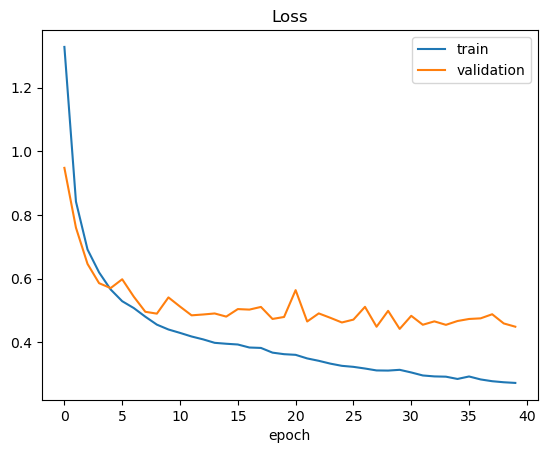

In [10]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.legend(['train','validation'])
plt.title("Loss")
plt.xlabel("epoch")
plt.show()

In [11]:
# early stopping 시점의 최고 성능 모델을 복원하는 과정이야.
resnet.load_state_dict(torch.load(PATH)) # 모델 파라메타 불러오기

<All keys matched successfully>

In [12]:
# 평가 데이터를 이용해 정확도를 구해보자.
# output은 미니배치의 결과가 산출되기 때문에 for문을 통해서 test 전체의 예측값을 구한다.

correct = 0 # 맞춘 개수 누적
total = 0 # 전체 데이터 개수 누적

with torch.no_grad(): # 평가 시에는 gradient 계산이 필요 없다.
    resnet.eval()

    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1) # 각 샘플별로 가장 큰 값을 가진 클래스 인덱스를 반환 (모델이 가장 확신하는 클래스를 예측값으로 선택)
        total += labels.size(0) # 개수 누적(총 개수)
        correct += (predicted == labels).sum().item() # 누적(맞으면 1, 틀리면 0으로 합산)

print('Test accuracy: %.2f %%' % (100 * correct / total))

# ResNet18 (overfitting): 85 %
# ResNet18 (ealy stopping): 84.56 %

Test accuracy: 86.76 %
